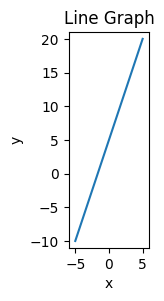

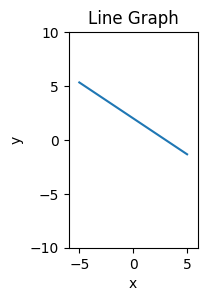

In [56]:

from pathlib import Path
from tkinter import Tk, Canvas, Entry, Text, Button, PhotoImage, Label
from tkinter.ttk import Combobox  # Import Combobox from ttk
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

OUTPUT_PATH = Path().resolve()
ASSETS_PATH = OUTPUT_PATH /"frame0"

def relative_to_assets(path: str) -> Path:
    return ASSETS_PATH / Path(path)
def calculate_and_plot():
    try:
        # Get input values
        slope_input = entry_1.get()  # Slope input
        point1_input = entry_2.get()  # Point 1 input
        point2_input = entry_3.get()  # Point 2 input
        equation_input = entry_4.get()  # Line equation input (prioritized)

        # Initialize variables
        slope = None
        intercept = None

        # Prioritize Entry 4 (Equation Input)
        if equation_input:
            # Remove spaces
            equation_input = equation_input.replace(" ", "")
            
            if "x" in equation_input and "y" in equation_input and "=" in equation_input and not equation_input.startswith("y=") and "(x" not in equation_input:
                # Example: 2x + 3y = 6
                left_side, right_side = equation_input.split("=")
                right_side = float(right_side)
                terms = left_side.replace(" ", "").replace("-", "+-").split("+")  # Split into terms, handling both signs
                
                A = B = 0
                for term in terms:
                    if "x" in term:
                        # Extract the coefficient of x, which might have a sign
                        A = float(term.replace("x", "").strip() if term != "x" else "1")  # Handles cases like "x" or "-x" or "+x"
                    elif "y" in term:
                        # Extract the coefficient of y, which might have a sign
                        B = float(term.replace("y", "").strip() if term != "y" else "1")  # Handles cases like "y" or "-y" or "+y"
                
                slope = -A / B if B != 0 else 0  # Slope is -A/B
                intercept = right_side / B if B != 0 else 0  # Intercept is C/B if B != 0
            
            elif "y" in equation_input and "=" in equation_input and "(x" in equation_input:  # Point-Slope Form
                # Example: y + 2 = 3(x - 1)
                match = re.match(r"y\s*([\+\-]?\s*\d+)\s*=\s*([\+\-]?\d+)\(x\s*([\+\-]?\s*\d+)\)", equation_input)
                if match:
                    y_part = match.group(1).strip()
                    slope_part = match.group(2).strip()
                    x_part = match.group(3).strip()
            
                    # Extract y1 (from y + 2 or y - 2)
                    y1 = float(y_part.replace(' ', '').replace('+', ''))
                    
                    # Extract slope and x1 (from 3(x-1))
                    slope = float(slope_part)
                    x1 = float(x_part.replace('(', '').replace(')', '').replace(' ', '').replace('+', ''))
            
                    intercept = y1 - slope * x1  # Calculate y-intercept

                
                else:
                    raise ValueError("Invalid point-slope format. Example: y + 2 = 3(x - 1)")
            
            elif "y=" in equation_input and "(x" not in equation_input:  # Slope-Intercept Form (y = mx + b)
                # Example: y = 2x + 3
                left_side, right_side = equation_input.split("=")
                if "x" in right_side:
                    parts = right_side.split("x")
                    slope = float(parts[0].strip() if parts[0].strip() not in ["", "+", "-"] else "1" if parts[0] == "" else "-1")  # Handle cases like "x" or "-x"
                    intercept = float(parts[1].strip()) if len(parts) > 1 else 0
                else:
                    slope = 0
                    intercept = float(right_side)


            else:
                raise ValueError("Unsupported equation format. Use y=mx+b, y-y1=m(x-x1), or Ax+By=C.")
        else:
            # Use other inputs if Entry 4 is not provided
            slope = float(slope_input) if slope_input else None
            point1 = None
            if point1_input:
                try:
                    point1 = tuple(map(float, point1_input.split(',')))
                    if len(point1) != 2:
                        raise ValueError("Point must have exactly two coordinates.")
                except Exception:
                    raise ValueError("Invalid Point 1 format. Use the format x,y.")
            
            point2 = None
            if point2_input:
                try:
                    point2 = tuple(map(float, point2_input.split(',')))
                    if len(point2) != 2:
                        raise ValueError("Point must have exactly two coordinates.")
                except Exception:
                    raise ValueError("Invalid Point 2 format. Use the format x,y.")

            if point1 and point2:
                x1, y1 = point1
                x2, y2 = point2
                slope = (y2 - y1) / (x2 - x1) if (x2 - x1) != 0 else 0
                intercept = y1 - slope * x1
            elif slope is not None and point1:
                intercept = point1[1] - slope * point1[0]
            else:
                raise ValueError("Provide either an equation, a slope with a valid point, or two points.")

        # Calculate X-Intercept: Set y = 0 in the equation y = mx + b
        x_intercept = -intercept / slope if slope != 0 else None

        # Prepare all forms of the equation
        slope_intercept_form = f"Slope-Intercept Form: y = {slope:.2f}x + {intercept:.2f}"
        point_slope_form = f"Point-Slope Form: y - {intercept:.2f} = {slope:.2f}(x - 0)"
        A = -slope if slope else 0
        B = 1  # Coefficient of y
        C = intercept if intercept else 0
        standard_form = f"Standard Form: {-A:.2f}x + {B:.2f}y = {C:.2f}"

        # Prepare the result text
        result_text = slope_intercept_form + "\n"
        result_text += point_slope_form + "\n"
        result_text += standard_form + "\n\n"
        result_text += f"Slope: {slope}\n"
        result_text += f"Y-Intercept: {intercept}\n"
        if x_intercept is not None:
            result_text += f"X-Intercept: {x_intercept:.2f}\n"
        else:
            result_text += "X-Intercept: Undefined (vertical line)\n"

        # Table of values for x = -5 to 5
        table_values = []
        for x in range(-5, 6):
            y = slope * x + intercept
            table_values.append(f"x = {x}, y = {y:.2f}")

        # Show the table of values
        result_text += "\nTable of Values:\n" + "\n".join(table_values)

        # Update the result label with all forms and table of values
        canvas.itemconfig(result_label, text=f"{result_text}")

        # Plot the line graph if possible
        plot_line(slope, intercept)

    except ValueError as e:
        canvas.itemconfig(result_label, text=f"Error: {e}")



# Function to plot the line
def plot_line(slope, intercept, min_x=-5, max_x=5):
    # Remove the default image if it exists
    canvas.delete("default_image")  # Delete only the image with the tag "default_image"

    fig, ax = plt.subplots(figsize=(3, 2.8))  # Set figure size to 5x5 inches

    # Make the figure background transparent
    fig.patch.set_visible(False)
    ax.set_facecolor('none')  # Transparent background for the axes

    # Calculate y-values for the line equation
    x_values = list(range(min_x, max_x + 1))
    y_values = [slope * x + intercept for x in x_values]

    # Plot the line
    ax.plot(x_values, y_values, label=f'y = {slope}x + {intercept}')

    # Add labels and title
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('Line Graph')

    # Set axis limits and equal aspect ratio
    ax.set_xlim(min_x - 1, max_x + 1)
    ax.set_ylim(min(min(y_values) - 1, -10), max(max(y_values) + 1, 10))
    ax.set_aspect('equal', 'box')

    # Display the plot on the Tkinter window
    canvas_plot = FigureCanvasTkAgg(fig, window)
    canvas_plot.get_tk_widget().place(x=30.0, y=130.0)  # Place the graph at the specified coordinates
    canvas_plot.draw()



window = Tk()

window.geometry("700x550")
window.configure(bg = "#FFE873")


canvas = Canvas(
    window,
    bg = "#FFE873",
    height = 550,
    width = 700,
    bd = 0,
    highlightthickness = 0,
    relief = "ridge"
)

canvas.place(x = 0, y = 0)
canvas.create_rectangle(
    0.0,
    0.0,
    700.0,
    94.0,
    fill="#306998",
    outline="")

canvas.create_text(
    17.0,
    12.0,
    anchor="nw",
    text="Graphing Tool for \nBasic Trigonometric Functions",
    fill="#FFFFFF",
    font=("Murecho SemiBold", 32 * -1)
)

canvas.create_rectangle(
    0.0,
    523.0,
    700.0,
    550.0,
    fill="#306998",
    outline="")


canvas.create_text(
    349.0,
    110.0,
    anchor="nw",
    text="Table",
    fill="#000000",
    font=("Murecho SemiBold", 20 * -1)
)

# Load and assign image 1
image_image_1 = PhotoImage(file=relative_to_assets("image_1.png"))
window.image_image_1 = image_image_1  # Retain reference to avoid garbage collection
image_1 = canvas.create_image(
    175.0,
    283.0,
    image=image_image_1,
    tags="default_image"
)

# Load and assign image 2
image_image_2 = PhotoImage(file=relative_to_assets("image_2.png"))
window.image_image_2 = image_image_2  # Retain reference to avoid garbage collection
image_2 = canvas.create_image(
    520.0,
    283.0,
    image=image_image_2
)

canvas.create_text(
    5.0,
    110.0,
    anchor="nw",
    text="Graph",
    fill="#000000",
    font=("Murecho SemiBold", 20 * -1),
    tags="default_image"
)

canvas.create_text(
    152.0,
    431.0,
    anchor="nw",
    text="Enter Point 1",
    fill="#306998",
    font=("Murecho SemiBold", 16 * -1)
)

canvas.create_text(
    284.0,
    431.0,
    anchor="nw",
    text="Enter Point 2",
    fill="#306998",
    font=("Murecho SemiBold", 16 * -1)
)

canvas.create_text(
    35.0,
    431.0,
    anchor="nw",
    text="Enter Slope",
    fill="#306998",
    font=("Murecho SemiBold", 16 * -1)
)

canvas.create_text(
    416.0,
    431.0,
    anchor="nw",
    text="Enter Equation",
    fill="#306998",
    font=("Murecho SemiBold", 16 * -1)
)

image_image_3 = PhotoImage(
    file=relative_to_assets("image_3.png"))
image_3 = canvas.create_image(
    659.9999967736619,
    43.0,
    image=image_image_3
)

entry_image_1 = PhotoImage(
    file=relative_to_assets("entry_1.png"))
entry_bg_1 = canvas.create_image(
    107.0,
    480.0,
    image=entry_image_1
)
entry_1 = Entry(
    bd=0,
    bg="#EDEDED",
    fg="#000716",
    highlightthickness=0
)
entry_1.place(
    x=59.0,
    y=465.0,
    width=96.0,
    height=28.0
)

entry_image_2 = PhotoImage(
    file=relative_to_assets("entry_2.png"))
entry_bg_2 = canvas.create_image(
    244.0,
    480.0,
    image=entry_image_2
)
entry_2 = Entry(
    bd=0,
    bg="#EDEDED",
    fg="#000716",
    highlightthickness=0
)
entry_2.place(
    x=196.0,
    y=465.0,
    width=96.0,
    height=28.0
)

entry_image_3 = PhotoImage(
    file=relative_to_assets("entry_3.png"))
entry_bg_3 = canvas.create_image(
    374.0,
    480.0,
    image=entry_image_3
)
entry_3 = Entry(
    bd=0,
    bg="#EDEDED",
    fg="#000716",
    highlightthickness=0
)
entry_3.place(
    x=326.0,
    y=465.0,
    width=96.0,
    height=28.0
)

entry_image_4 = PhotoImage(
    file=relative_to_assets("entry_4.png"))
entry_bg_4 = canvas.create_image(
    500.0,
    480.0,
    image=entry_image_4
)
entry_4 = Entry(
    bd=0,
    bg="#EDEDED",
    fg="#000716",
    highlightthickness=0
)
entry_4.place(
    x=452.0,
    y=465.0,
    width=96.0,
    height=28.0
)

button_image_1 = PhotoImage(file=relative_to_assets("button_1.png"))
button_1 = Button(
    image=button_image_1,
    borderwidth=0,
    highlightthickness=0,
    command=calculate_and_plot,  # Call the function when the button is clicked
    relief="flat"
)
button_1.place(
    x=589.0,
    y=450.0,
    width=83.0,
    height=50.0
)


result_label = canvas.create_text(500, 280, text="", fill="black", font=("Arial", 8))

window.resizable(False, False)
window.mainloop()
